# 細胞核影像分割

# 匯入所需套件

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 資料集讀取

In [ ]:
!unzip nuclei_data.zip

Archive:  nuclei_data.zip
   creating: nuclei_data/
   creating: nuclei_data/images/
  inflating: nuclei_data/images/img0000.png  
  inflating: nuclei_data/images/img0001.png  
  inflating: nuclei_data/images/img0002.png  
  inflating: nuclei_data/images/img0003.png  
  inflating: nuclei_data/images/img0004.png  
  inflating: nuclei_data/images/img0005.png  
  inflating: nuclei_data/images/img0006.png  
  inflating: nuclei_data/images/img0007.png  
  inflating: nuclei_data/images/img0008.png  
  inflating: nuclei_data/images/img0009.png  
  inflating: nuclei_data/images/img0010.png  
  inflating: nuclei_data/images/img0011.png  
  inflating: nuclei_data/images/img0012.png  
  inflating: nuclei_data/images/img0013.png  
  inflating: nuclei_data/images/img0014.png  
  inflating: nuclei_data/images/img0015.png  
  inflating: nuclei_data/images/img0016.png  
  inflating: nuclei_data/images/img0017.png  
  inflating: nuclei_data/images/img0018.png  
  inflating: nuclei_data/images/img0019.p

In [ ]:
def get_data_list(data_path):
  data_list = []
  for i in os.listdir(data_path):
      if i.endswith('.png'):
          img_path = os.path.join(data_path, i)
          data_list.append(img_path)
      
  data_list.sort()
  return data_list

In [ ]:
train_val_imgs = get_data_list('nuclei_data/images')
train_val_masks = get_data_list('nuclei_data/labels')
test_imgs = get_data_list('nuclei_data/test_images')
test_masks = get_data_list('nuclei_data/test_labels')

print('Total number of training and validation image data:', len(train_val_imgs))
print('Total number of training and validation mask data:', len(train_val_masks))
print('Total number of test image data:', len(test_imgs))
print('Total number of test mask data:', len(test_masks))

Total number of training and validation image data: 590
Total number of training and validation mask data: 590
Total number of test image data: 10
Total number of test mask data: 10


## 觀察資料

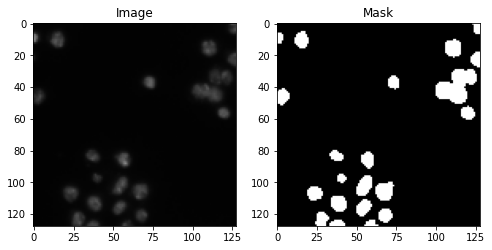

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_title('Image')
img = cv2.imread(train_val_imgs[0])
axes[0].imshow(img)

mask = cv2.imread(train_val_masks[0]).squeeze()
axes[1].set_title('Mask')
axes[1].imshow(mask, cmap='gray')

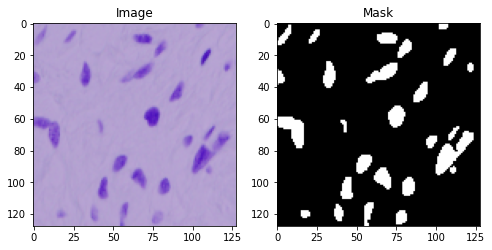

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_title('Image')
img = cv2.imread(train_val_imgs[2])
axes[0].imshow(img)

mask = cv2.imread(train_val_masks[2]).squeeze()
axes[1].set_title('Mask')
axes[1].imshow(mask, cmap='gray')

# 資料集劃分

通常會將資料集劃分為訓練集 (training set)、驗證集 (validation set)、測試集 (test set)


*   訓練集 (training set)：用於訓練模型參數
*   驗證集 (validation set)：用於檢驗模型的訓練狀況，作為調整超參數的依據
*   測試集 (test set)：評估模型的表現結果


In [ ]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(train_val_imgs, train_val_masks, test_size=0.1, random_state=1)

In [ ]:
print('Total number of training image data:', len(train_imgs))
print('Total number of traing mask data:', len(train_masks))
print('Total number of validation image data:', len(val_imgs))
print('Total number of validation mask data:', len(val_masks))
print('Total number of test image data:', len(test_imgs))
print('Total number of test mask data:', len(test_masks))

Total number of training image data: 531
Total number of traing mask data: 531
Total number of validation image data: 59
Total number of validation mask data: 59
Total number of test image data: 10
Total number of test mask data: 10


# 資料前處理 Data Preprocessing

在訓練模型前，需要先對資料進行前處理，將資料調整為適合模型輸入的格式。


Original image shape: (128, 128, 3)
Processed image shape: (128, 128, 3)


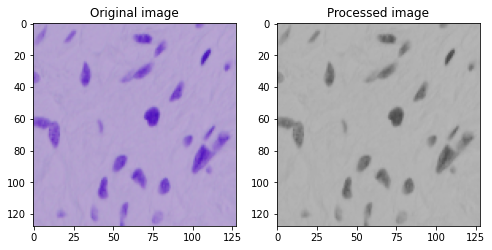

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_title('Original image')
org_img = cv2.imread(train_val_imgs[2])
axes[0].imshow(org_img)

img = cv2.imread(train_val_imgs[2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # 若模型輸入為 1 channel 就不需要再轉成 BGR
axes[1].set_title('Processed image')
axes[1].imshow(img)

print('Original image shape:', org_img.shape)
print('Processed image shape:', img.shape)

In [ ]:
def load_img(data_list, img_size):
    data_img = []
    for i in data_list:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.
        data_img.append(img)

    data_img = np.array(data_img)
    return data_img

def load_mask(mask_list, img_size):
    data_mask = []
    for i in mask_list:
        mask = cv2.imread(i, 0)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.        
        
        data_mask.append(mask)
        
    data_mask = np.array(data_mask)
    data_mask = np.expand_dims(data_mask, -1)
    return data_mask

In [ ]:
img_size = 256
train_x = load_img(train_imgs, img_size)
train_y = load_mask(train_masks, img_size)

val_x = load_img(val_imgs, img_size)
val_y = load_mask(val_masks, img_size)

test_x = load_img(test_imgs, img_size)
test_y = load_mask(test_masks, img_size)

print("Shape of train_x: ", train_x.shape)
print("Shape of train_y: ", train_y.shape)
print("Shape of val_x: ", val_x.shape)
print("Shape of val_y: ", val_y.shape)
print("Shape of test_x: ", test_x.shape)
print("Shape of test_y: ", test_y.shape)

Shape of train_x:  (531, 256, 256, 3)
Shape of train_y:  (531, 256, 256, 1)
Shape of val_x:  (59, 256, 256, 3)
Shape of val_y:  (59, 256, 256, 1)
Shape of test_x:  (10, 256, 256, 3)
Shape of test_y:  (10, 256, 256, 1)


# 資料增強 Data Augmentation

資料增強是一種通過現有資料來擴增原有資料的方式，藉由生成更多資料以防止模型過擬合 (over-fitting) ，並提升模型準確率。

以下會來介紹幾種 Data Augmentation 方法，除此之外，tensorflow 還提供了許多種的方法，可參考：[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

## 旋轉 Rotation
 * rotation_range：整數，0 ~ 360  (default：0)
 * 隨機從 0 ~ rotation_range 選取角度，任意順時或逆時旋轉

In [ ]:
def my_plot(org_img, aug_img, batch_size):
    plt.figure(figsize=(7,14))
    for i in range(batch_size//2):
        plt.subplot(4,2,i*2+1)
        plt.title('Original image')
        plt.imshow(org_img[i])
        plt.subplot(4,2,i*2+2)
        plt.title('Data Augmentation')
        plt.imshow(aug_img[i])

    plt.show()

In [ ]:
datagen = ImageDataGenerator(rotation_range=120) 

In [ ]:
image_generator = datagen.flow(train_x[:8], batch_size=8, seed=4, shuffle=False)
mask_datagen = datagen.flow(train_y[:8], batch_size=8, seed=4, shuffle=False)
train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))

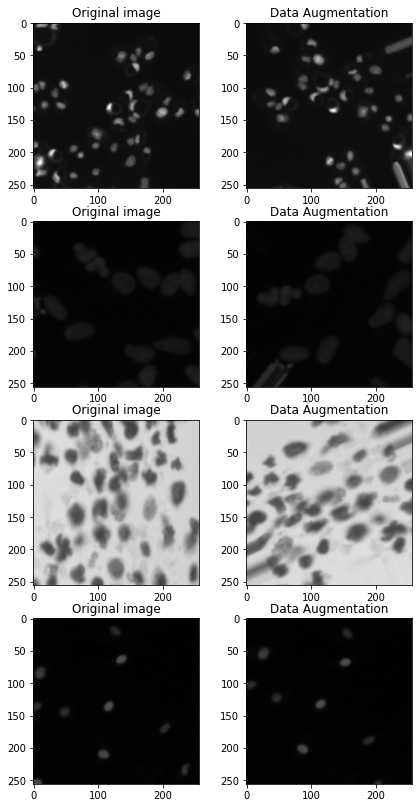

In [ ]:
img, label = next(train_combined_generator)
my_plot(train_x[:8], img, 8)

## 平移 Shift
 * width_shift_range：0 ~ 1 (default：0)
 * height_shift_range：0 ~ 1 (default：0)
 * 隨機從寬度 (width) 或高度 (height) 平移 0 ~ shift_range

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.5, height_shift_range=0.5)

In [ ]:
image_generator = datagen.flow(train_x[:8], batch_size=8, seed=9, shuffle=False)
mask_datagen = datagen.flow(train_y[:8], batch_size=8, seed=9, shuffle=False)
train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))

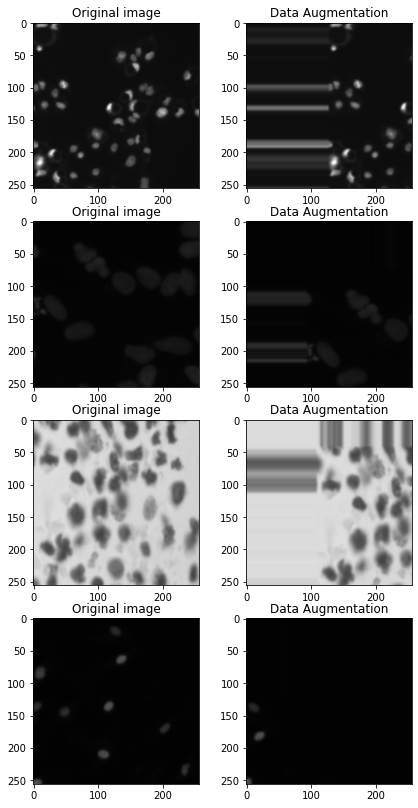

In [ ]:
img, label = next(train_combined_generator)
my_plot(train_x[:8], img, 8)

## 縮放 Zoom
 * zoom_range: Float or [lower, upper] (default：0)
 * 隨機從 0 ~ zoom_range 進行縮放

In [ ]:
datagen = ImageDataGenerator(zoom_range=0.5)

In [ ]:
image_generator = datagen.flow(train_x[:8], batch_size=8, seed=42, shuffle=False)
mask_datagen = datagen.flow(train_y[:8], batch_size=8, seed=42, shuffle=False)
train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))

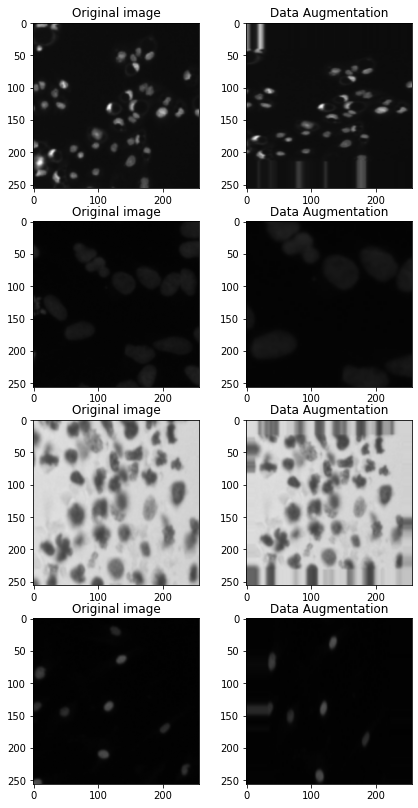

In [ ]:
img, label = next(train_combined_generator)
my_plot(train_x[:8], img, 8)

## 翻轉 Flip

 * horizontal_flip：True or False (default：False)
 * vertical_flip：True or False (default：False)
 * 如果為 True，隨機決定是否執行水平或垂直翻轉

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

In [ ]:
image_generator = datagen.flow(train_x[:8], batch_size=8, seed=3, shuffle=False)
mask_datagen = datagen.flow(train_y[:8], batch_size=8, seed=3, shuffle=False)
train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))

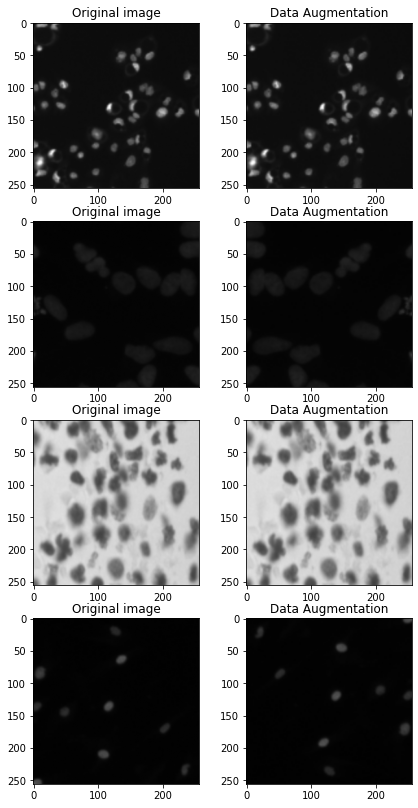

In [ ]:
img, label = next(train_combined_generator)
my_plot(train_x[:8], img, 8)

## 補值 Fill
 * fill_mode：共有 'nearest', 'constant', 'reflect', 'wrap' 方法  (default：'nearest')
 * 根據 fill_mode 填充邊界之外的點
 * 若 fill_mode 為 'constant' 可設定 cval 以指定補入的顏色值

mode:  nearest


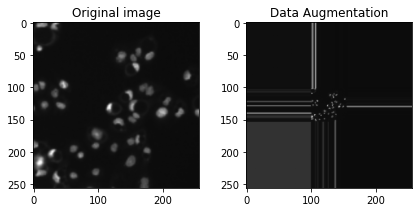

mode:  constant


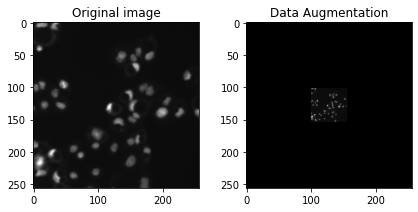

mode:  reflect


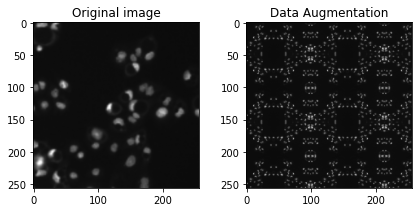

mode:  wrap


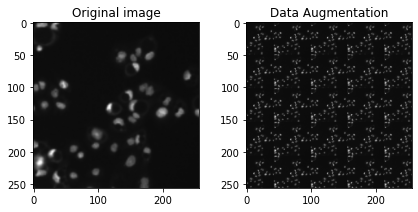

In [ ]:
mode_list = ['nearest', 'constant', 'reflect', 'wrap']

for mode in mode_list:
  print("mode: ", mode)
  datagen  = ImageDataGenerator(zoom_range=[1,5], fill_mode=mode)
  image_generator = datagen.flow(train_x[:2], batch_size=2, seed=8, shuffle=False)
  mask_datagen = datagen.flow(train_y[:2], batch_size=2, seed=6, shuffle=False)
  train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))
  img, label = next(train_combined_generator)
  my_plot(train_x[:2], img, 2)

## 實際操作

所有要使用的 Data Augmentation 方法都可以寫在字典裡，再經過 ImageDataGenerator 實現。

這邊使用 `.flow(x,y)` 運用在訓練資料上，也可以直接運用在資料夾上 (`.flow_from_directory(directory)`)，使用方式可參考: [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

另外，`.flow(x,y)` 運用在訓練圖像 (train_image) 和標籤 (train_mask) 裡都要需要設定相同的 seed 值，兩者的資料生成方式才會對應到。

In [ ]:
aug_dict = dict(rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        )

datagen = ImageDataGenerator(**aug_dict)

In [ ]:
batch_size = 32
image_generator = datagen.flow(train_x, batch_size=batch_size, seed=1)
mask_datagen = datagen.flow(train_y, batch_size=batch_size, seed=1)
train_combined_generator = (pair for pair in zip(image_generator, mask_datagen))

# 模型建立及編譯

## 建立模型
依照 U-Net 結構建立模型，可設定輸入 image_size 及最後輸出的類別數

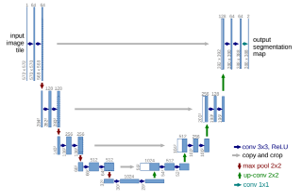

In [ ]:
def Unet(image_size, num_class):
   
    inputs = Input(shape=image_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)
    
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(num_class, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

## Loss function

這邊 loss function 使用 dice loss，公式如下：


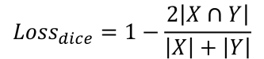

In [ ]:
def dice_loss(y_true, y_pred): # No gamma, no smooth
    '''
    https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
    '''
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

## 編譯模型

實例化模型後，要將其進行編譯，模型編譯的參數主要有優化器 (optimizer)、損失函數 (loss)、指標 (metric)，除此之外，還有其他參數可以設定，可參考：[tensorflow compile 官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

tensorflow 官方提供的參數：


*   optimizer：[Module: tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

*   loss：[Module: tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

*   metric：[Module: tf.keras.metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)





In [ ]:
model = Unet(image_size=[256, 256, 3], num_class=1)
model.compile(optimizer = Adam(learning_rate = 1e-3), loss = dice_loss,
              metrics = [tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])])

# Callback

Callback 應用於訓練階段，若達到設定的條件便會觸發調用 Callback 操作，能夠監控及察看模型的訓練過程。

以下使用幾種 Callback 方法:

* ModelCheckpoint：在訓練過程中，將模型進行儲存

* EarlyStopping：監控是否需要提早結束訓練

* ReduceLROnPlateau：當模型的訓練狀態無法再更好時，降低學習率 (learning rate)

除此之外，tensorflow 還提供了許多種的 Callback，可參考：[Module: tf.keras.callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)


In [ ]:
model_dir = 'model_saved'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
modelfiles = os.path.join(model_dir, 'best_model.h5')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles, 
                       monitor='val_loss', # 設置要監控哪個數據
                       save_best_only=True, 
                       save_weights_only=False, # 是否只儲存模型權重，若為 False 會儲存整個模型
                       mode='auto') # 設定覆蓋模型的方向，根據被監控數據選擇 auto, min, max 三種

                      # min: 被監控數據變小，則覆蓋原模型，應用於 val_loss；
                      # max: 被監控數據變大，則覆蓋原模型，應用於 val_acc；
                      # auto: 根據被監控數據名稱自動判斷

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                      patience=30, # 容忍在多少 epoch 內，監控的數據結果沒有進步
                      verbose=1) # 輸出訊息設置: 0 表示不輸出、 1 表示會輸出

reduce_lr = keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.1, # learning rate 縮放的值，new learning rate = org learning rate * factor
                    patience=5,
                    mode='auto', # 設定監控數據的改善方向，可選擇 auto, min, max 三種
                    min_delta=0.0001, # 監控數據的最小改善標準，數據變動幅度小於該值表示沒有進步
                    cooldown=0, # learning rate 改變後，需經過多少 epoch 再重新正常運作
                    min_lr=0) # learning rate 的最低下界

callbacks_list = [model_mckp, earlystop, reduce_lr]

# 模型訓練

使用 `model.fit()` 進行訓練，輸入設定為經過 Data Augmentation 後的資料；validation_data 設定為劃分好的驗證集資料，其中驗證集不需做 Data Augmentation。

若需要 callback 進行監控，則將所有要使用的 callback 方法包裝成一個 list 傳入。

In [ ]:
epochs = 20

history = model.fit(train_combined_generator,
        epochs=epochs,
        validation_data=(val_x, val_y), 
        steps_per_epoch=len(train_x) // batch_size, 
        callbacks=callbacks_list)

Epoch 1/20
16/16 [==============================] - 39s 1s/step - loss: 0.7516 - io_u: 0.4408 - val_loss: 0.7128 - val_io_u: 0.3565 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - 21s 938ms/step - loss: 0.7366 - io_u: 0.4730 - val_loss: 0.7076 - val_io_u: 0.4353 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - 14s 877ms/step - loss: 0.7292 - io_u: 0.4987 - val_loss: 0.7047 - val_io_u: 0.4710 - lr: 0.0010
Epoch 4/20
16/16 [==============================] - 14s 872ms/step - loss: 0.7187 - io_u: 0.4968 - val_loss: 0.6833 - val_io_u: 0.4454 - lr: 0.0010
Epoch 5/20
16/16 [==============================] - 14s 894ms/step - loss: 0.7079 - io_u: 0.5105 - val_loss: 0.6829 - val_io_u: 0.4808 - lr: 0.0010
Epoch 6/20
16/16 [==============================] - 14s 877ms/step - loss: 0.7078 - io_u: 0.5060 - val_loss: 0.6798 - val_io_u: 0.4763 - lr: 0.0010
Epoch 7/20
16/16 [==============================] - 14s 874ms/step - loss: 0.7007 - io_u: 0.5252 - val_loss: 0.6794

# 訓練結果視覺化

In [ ]:
def plot_history(history_value):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(history_value.history['io_u'])
    plt.plot(history_value.history['val_io_u'])
    plt.ylabel('IoU')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.title('Model IoU')

    plt.subplot(1,2,2)
    plt.plot(history_value.history['loss'])
    plt.plot(history_value.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.title('Model Loss')

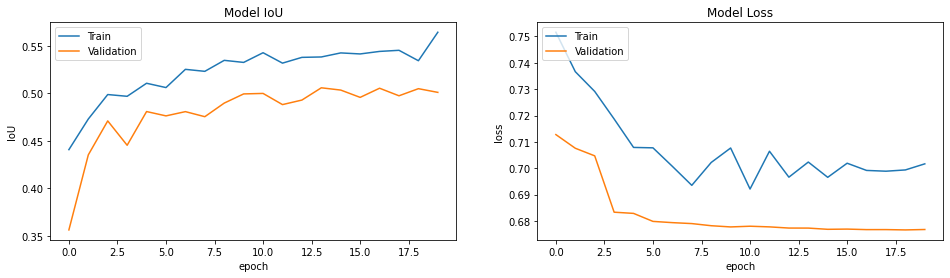

In [ ]:
plot_history(history)

# 模型評估

使用測試集來評估模型的訓練結果

In [ ]:
test_loss, test_iou = model.evaluate(test_x, test_y, batch_size=32)
print("test loss:", test_loss)
print("test IoU:", test_iou)

1/1 [==============================] - 2s 2s/step - loss: 0.6734 - io_u: 0.4646
test loss: 0.6734253168106079
test IoU: 0.4646231532096863


# 模型預測

1/1 [==============================] - 0s 229ms/step


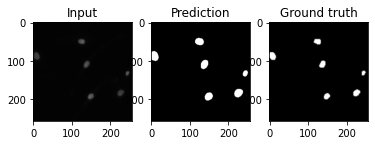

IoU:  0.7187623


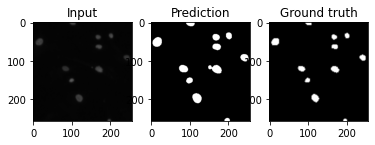

IoU:  0.6943657


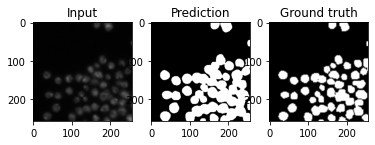

IoU:  0.68812263


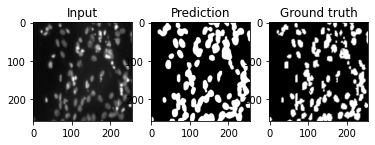

IoU:  0.6502226


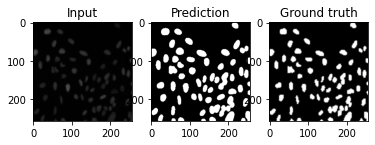

IoU:  0.6580998


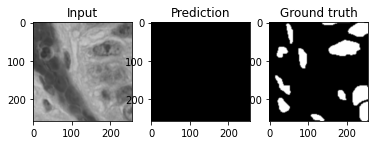

IoU:  0.073638916


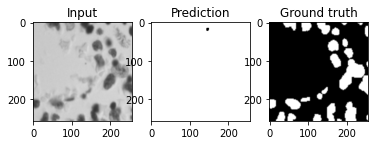

IoU:  0.081848145


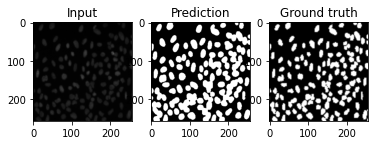

IoU:  0.5898769


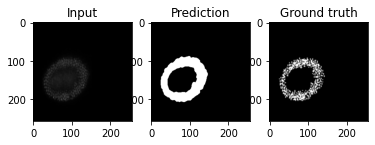

IoU:  0.48861012


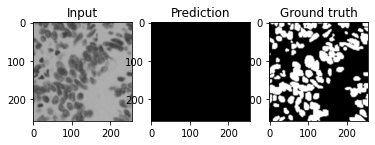

IoU:  0.14526367


In [ ]:
num=10
preds = model.predict(test_x[:num])
for i in range(num):
    _, axes = plt.subplots(1, 3, figsize=(6, 2))
    axes[0].set_title('Input')
    axes[0].imshow(test_x[:num][i].squeeze(), 'gray')
    
    pred_mask = preds[i]
    pred_mask[pred_mask > 0.5] = 1
    pred_mask[pred_mask <= 0.5] = 0
    _pred = pred_mask.squeeze()
    axes[1].set_title('Prediction')
    axes[1].imshow(_pred, cmap='gray')
    
    _gt = test_y[:num][i].squeeze()
    axes[2].set_title('Ground truth')
    axes[2].imshow(_gt, cmap='gray')
    plt.show()

    m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])
    m.reset_state()
    m.update_state(test_y[:num][i].squeeze(), pred_mask.squeeze())
    print("IoU: ", m.result().numpy())
